In [29]:
import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
import xlmhg

In [60]:
def load_pathway_library(path='../c2.all.v6.0.symbols.gmt', vocab_path='../dataset/preprocessed/human_melanoma_data_column_lbls.npy'):
    vocab = np.load(vocab_path)
    gene_sets = []
    gene_set_sizes = []
    gene_set_names = []

    print('Loading gene sets...(can take a few minutes)')
    # load gene sets from msigdb file
    with open(path, 'r') as file:
        reader = csv.reader(file, delimiter = '\t')
        for idx, row in enumerate(reader):
            gene_set_names.append(row[0])
            genes = np.array(row[2:])
            genes = genes[np.in1d(genes,vocab)]
            gene_sets.append(genes)
            gene_set_sizes.append(len(genes))

    gene_set_names = np.array(gene_set_names)
    gene_set_sizes = np.array(gene_set_sizes)

    idx = np.argwhere(gene_set_sizes>10).squeeze()

    names = gene_set_names[idx]
    sets = [gene_sets[i] for i in idx]
    sizes = gene_set_sizes[idx]
    
    return (names, sets, sizes)

def enrichment_mHGtest(pathway_lib, ranked_genes, n_sig_pathways = 6, enrichment_minimum_n = 5, lowest_cutoff = 15):

    names, sets, sizes = pathway_lib
    
    all_pvals = []
    all_pathways = []

    for idx, gene_list in enumerate(ranked_genes):
        scores = []
        for msigdbset in sets:
            gene_in_set = np.in1d(gene_list, msigdbset)+0
            _,_,pval = xlmhg.xlmhg_test(gene_in_set, enrichment_minimum_n, lowest_cutoff)
            scores.append(pval)
        scores = np.array(scores)

        min_indices = np.argpartition(scores, n_sig_pathways)[0:n_sig_pathways]
        min_scores = scores[min_indices]
        best_pathways = names[min_indices]
        min_indices = np.argsort(min_scores)
        min_scores = min_scores[min_indices]
        best_pathways = best_pathways[min_indices]

        all_pvals.append(min_scores)
        all_pathways.append(best_pathways)

    return all_pvals, all_pathways

In [31]:
genes = np.load('../dataset/preprocessed/human_melanoma_data_column_lbls.npy')

with open('all_lda_results.txt') as f:
    lines = f.readlines()

def filt(x):
    cond1 = x.strip().startswith("Iteration")
    cond2 = x.strip().startswith("executing")
    cond3 = len(x.strip()) == 0
    cond4 = x.strip().startswith("/home/skoppula/")
    cond5 = x.strip().startswith("DeprecationWarning")
    cond6 = x.strip().startswith('Training data loaded')
    return not (cond1 or cond2 or cond3 or cond4 or cond5 or cond6)
    
lines = list(map(lambda x: x.strip(), list(filter(filt, lines[2:]))))
ovb_start = [i for i, line in enumerate(lines) if line.strip().startswith('online variational bayes')][0]
gibbs_start = [i for i, line in enumerate(lines) if line.strip().startswith('collapsed gibbs')][0]
ovb_log = lines[ovb_start+1:gibbs_start]
gibbs_log = lines[gibbs_start+1:]

In [32]:
gibbs_training_times = []
gibbs_topics = []
for line in gibbs_log:
    if line.startswith('number of clusters'):
        gibbs_topics.append([])
    elif line.startswith('training time'):
        num = line.split(':')[1].strip()
        gibbs_training_times.append(float(num))
    elif line.startswith('topic'):
        genes = line.split(':')[1].split(', ')
        gibbs_topics[-1].append(genes)
    else:
        print(line)
        
for i, cluster in enumerate(gibbs_topics):
    assert len(cluster) == [5,10,25,50][i]
    for topic in cluster:
        assert len(topic) == 15

print(gibbs_training_times)

[3606.1307184696198, 4364.870006561279, 7374.122565984726, 11073.419347763062]


In [33]:
ovb_training_times = []
ovb_perplexity = []
ovb_likelihood = []
ovb_topics = []

for line in ovb_log:
    if line.startswith('number of clusters'):
        ovb_topics.append([])
    elif line.startswith('perplexity'):
        num = line.split(':')[1].strip()
        ovb_perplexity.append(float(num))
    elif line.startswith('log likelihood'):
        num = line.split(':')[1].strip()
        ovb_likelihood.append(float(num))
    elif line.startswith('training time') or "training time" in line:
        num = line.split(':')[1].strip()
        ovb_training_times.append(float(num))
    elif line.startswith('topic'):
        genes = line.split(':')[1].split(', ')
        ovb_topics[-1].append(genes)
    else:
        print(line)
        
for i, cluster in enumerate(ovb_topics):
    assert len(cluster) == [5,10,25,50][i]
    for topic in cluster:
        assert len(topic) == 15

print(ovb_training_times)
print(ovb_perplexity)
print(ovb_likelihood)

[1020.749017238617, 1299.1935110092163, 1684.2391335964203, 2080.0099618434906]
[14690.4000738, 203398.362982, 3925483895.03, 1.48020331702e+16]
[-328693503.891, -418719761.339, -756761441.553, -1275506768.49]


In [ ]:
pathway_lib = load_pathway_library()

In [61]:
for i, topics in enumerate([gibbs_topics, ovb_topics]):
    if i == 0: print("GIBBS TOPICS")
    else: print("OVB TOPICS")
    for i in range(len([5,10,25,50])):
        print("\tcluster_size:",[5,10,25,50][i])
        all_pvals, all_pathways = enrichment_mHGtest(pathway_lib, topics[i])

        for j, pvals in enumerate(all_pvals):
            for k, pval in enumerate(pvals):
                if pval < 0.3:
                    print("\t\tmatch: topic ",j,", ", all_pathways[j][k], ", pval:",pval)

GIBBS TOPICS
	cluster_size: 5
	cluster_size: 10
		match: topic  1 ,  KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP , pval: 0.041958041958
		match: topic  1 ,  PILON_KLF1_TARGETS_DN , pval: 0.137062937063
		match: topic  6 ,  GRAESSMANN_APOPTOSIS_BY_DOXORUBICIN_DN , pval: 0.263736263736
	cluster_size: 25
		match: topic  8 ,  PILON_KLF1_TARGETS_DN , pval: 0.263736263736
		match: topic  22 ,  KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP , pval: 0.041958041958
		match: topic  22 ,  PILON_KLF1_TARGETS_DN , pval: 0.137062937063
		match: topic  22 ,  GRAESSMANN_APOPTOSIS_BY_DOXORUBICIN_DN , pval: 0.263736263736
	cluster_size: 50
		match: topic  2 ,  ROME_INSULIN_TARGETS_IN_MUSCLE_UP , pval: 0.193006993007
		match: topic  3 ,  PILON_KLF1_TARGETS_DN , pval: 0.00699300699301
		match: topic  6 ,  PILON_KLF1_TARGETS_DN , pval: 0.263736263736
		match: topic  7 ,  BLALOCK_ALZHEIMERS_DISEASE_UP , pval: 0.018648018648
		match: topic  17 ,  KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP , pval: 0.041958041958
		match: topi

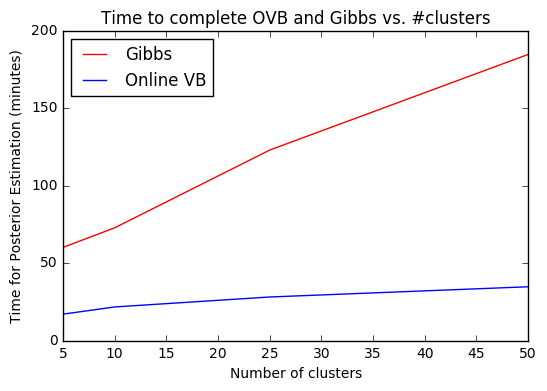

In [80]:
import matplotlib.pyplot as plt
plt.title("Time to complete OVB and Gibbs vs. #clusters")
plt.ylabel('Time for Posterior Estimation (minutes)')
plt.xlabel('Number of clusters')
plt.plot([5,10,25,50], np.array(gibbs_training_times)/60.0, 'r', label="Gibbs")
plt.plot([5,10,25,50], np.array(ovb_training_times)/60.0, 'b',  label="Online VB")
plt.legend(loc='upper left')

plt.show()

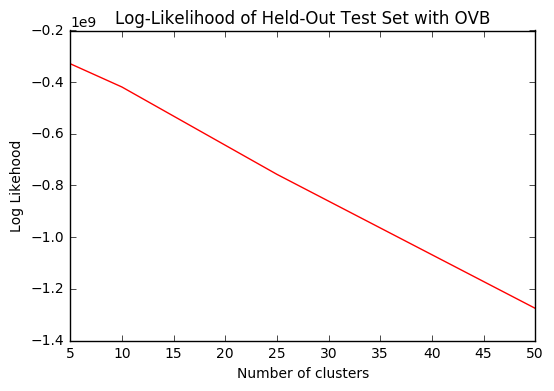

In [82]:
import matplotlib.pyplot as plt
plt.clf()
plt.title("Log-Likelihood of Held-Out Test Set with OVB")
plt.ylabel('Log Likehood')
plt.xlabel('Number of clusters')
plt.plot([5,10,25,50], np.array(ovb_likelihood), 'r')
plt.show()